In [1]:
!pip install split-folders
!pip install imutils
!pip install pydot
!pip install graphviz
!pip install opencv-python
!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import splitfolders
import cv2
import random
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imutils import paths
from keras.applications import VGG16
from keras.applications import ResNet50

In [3]:
# Paths and Parameters
inputFolder = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
outputFolder = '/kaggle/working/CT_dataset'
IMGSIZE = 128
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
random.seed(42)

In [4]:
# Dataset Split
splitfolders.ratio(inputFolder, outputFolder, seed=42, ratio=(0.8, 0.0, 0.2))
imgPaths = list(paths.list_images(outputFolder))
random.shuffle(imgPaths)

Copying files: 12446 files [01:20, 154.52 files/s]


In [5]:
# Data Loading
x_train, y_train, x_test, y_test = [], [], [], []

for imgPath in imgPaths:
    trainOrTest = imgPath.split('/')[-3]
    className = imgPath.split('/')[-2]
    
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    
    if trainOrTest == 'train':
        x_train.append(img)
        y_train.append(classes.index(className))
    elif trainOrTest == 'test':
        x_test.append(img)
        y_test.append(classes.index(className))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

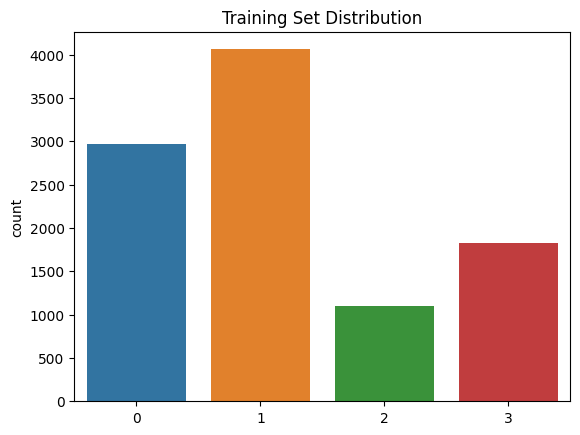

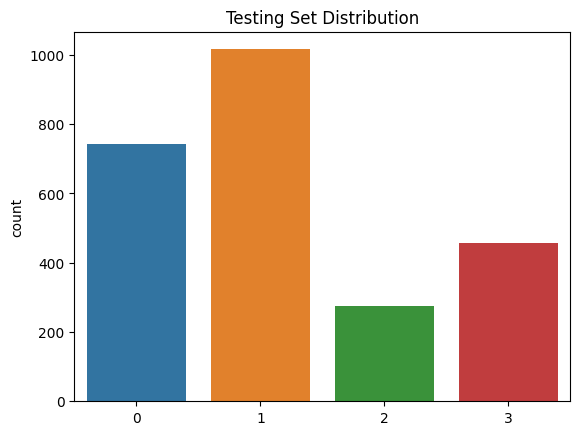

In [6]:
# Display Class Distribution
sb.countplot(x=y_train)
plt.title("Training Set Distribution")
plt.show()

sb.countplot(x=y_test)
plt.title("Testing Set Distribution")
plt.show()

In [7]:
# Normalize Data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Compute Class Weights (for imbalanced data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [8]:
# CNN Model
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMGSIZE, IMGSIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Train and Evaluate Model Function
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=25,
        class_weight=class_weights,
        batch_size=32
    )
    
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Plot Training History
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Confusion Matrix and Metrics
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.6312 - loss: 0.8429 - val_accuracy: 0.9972 - val_loss: 0.0156
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9893 - loss: 0.0363 - val_accuracy: 0.9980 - val_loss: 0.0086
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9924 - val_loss: 0.0240
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9898 - loss: 0.0318 - val_accuracy: 0.9996 - val_loss: 6.4892e-04
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9988 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 4.3336e-05
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9998 - loss: 9.0049e-04 - val_accuracy: 1.0000 - val_loss: 1.1684e-04
Epoch 7/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9975 - loss: 0.0090 - val_accuracy: 0.9952 - val_loss: 0.0124
Epoch 8/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9930 - loss: 

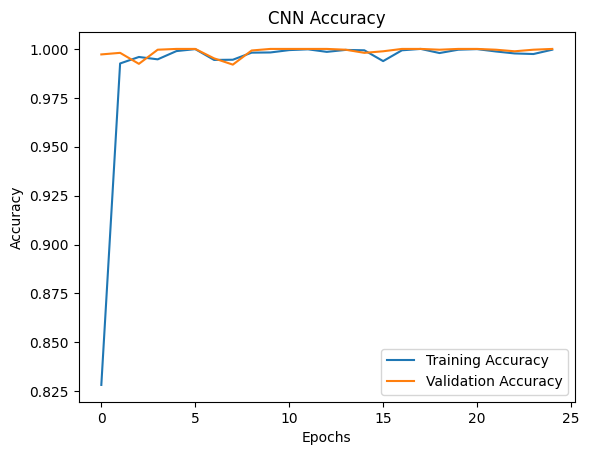

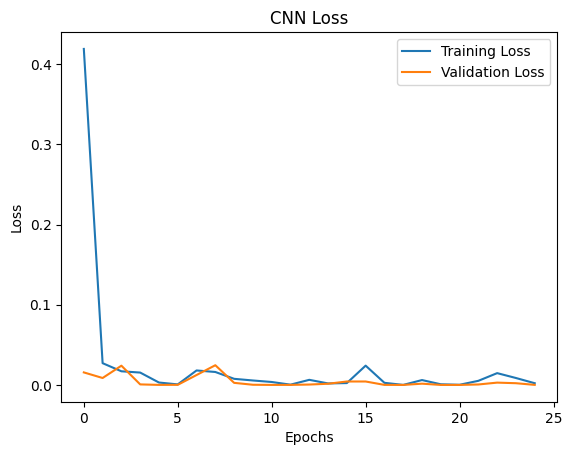

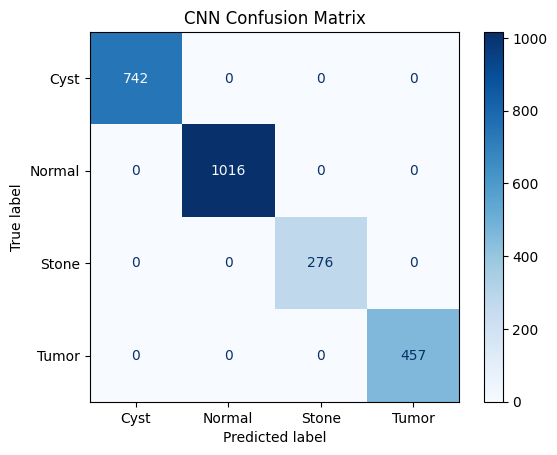

CNN Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      1.00      1.00       276
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2491
   macro avg       1.00      1.00      1.00      2491
weighted avg       1.00      1.00      1.00      2491

CNN Accuracy: 1.0000


In [10]:
# Train CNN
cnn = build_cnn()
train_and_evaluate_model(cnn, x_train, y_train, x_test, y_test, "CNN")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.3763 - loss: 1.4167 - val_accuracy: 0.7684 - val_loss: 0.7005
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5300 - loss: 0.9073 - val_accuracy: 0.8607 - val_loss: 0.4674
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5924 - loss: 0.7774 - val_accuracy: 0.9253 - val_loss: 0.2595
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6457 - loss: 0.6736 - val_accuracy: 0.9526 - val_loss: 0.1898
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6082 - loss: 0.7430 - val_accuracy: 0.9326 - val_loss: 0.2506
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6427 - loss: 0.6426 - val_accuracy: 0.9687 - val_loss: 0.1670
Epoch 7/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6624 - loss: 0.6113 - val_accuracy: 0.9787 - val_loss: 0.1424
Epoch 8/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29

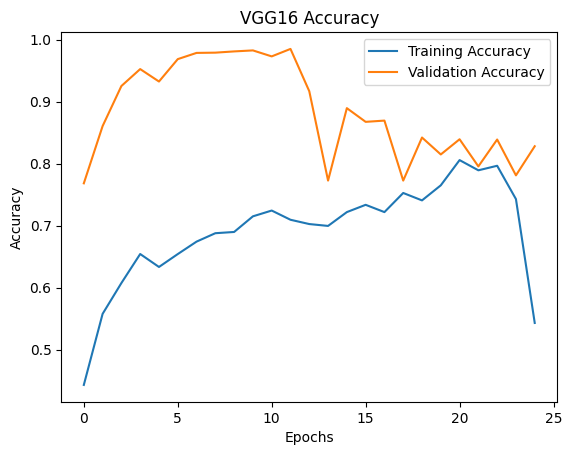

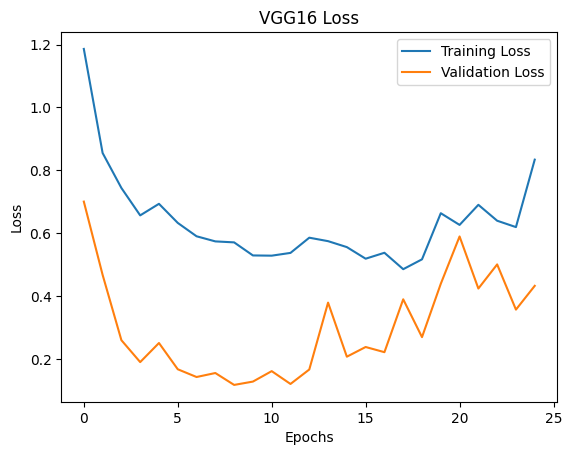

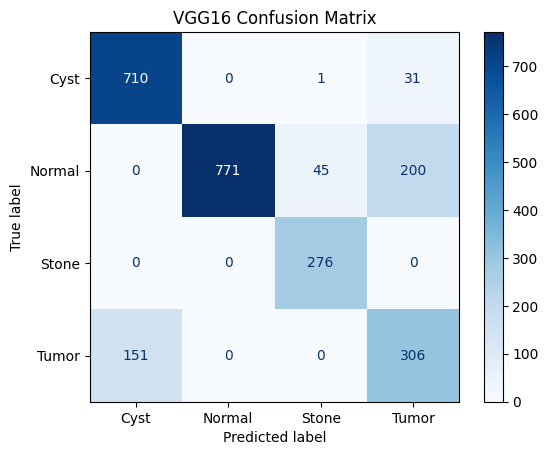

VGG16 Classification Report:
              precision    recall  f1-score   support

        Cyst       0.82      0.96      0.89       742
      Normal       1.00      0.76      0.86      1016
       Stone       0.86      1.00      0.92       276
       Tumor       0.57      0.67      0.62       457

    accuracy                           0.83      2491
   macro avg       0.81      0.85      0.82      2491
weighted avg       0.85      0.83      0.83      2491

VGG16 Accuracy: 0.8282


In [11]:
# VGG16

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMGSIZE, IMGSIZE, 3))
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_and_evaluate_model(vgg16_model, x_train, y_train, x_test, y_test, "VGG16")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.2358 - loss: 1.5399 - val_accuracy: 0.2979 - val_loss: 1.3825
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.2339 - loss: 1.3776 - val_accuracy: 0.4488 - val_loss: 1.3507
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.1607 - loss: 1.3877 - val_accuracy: 0.4613 - val_loss: 1.3380
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4279 - loss: 1.3619 - val_accuracy: 0.1497 - val_loss: 1.3511
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.2121 - loss: 1.3658 - val_accuracy: 0.4460 - val_loss: 1.3518
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3794 - loss: 1.3707 - val_accuracy: 0.4629 - val_loss: 1.3355
Epoch 7/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3211 - loss: 1.3385 - val_accuracy: 0.5929 - val_loss: 1.2551
Epoch 8/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26

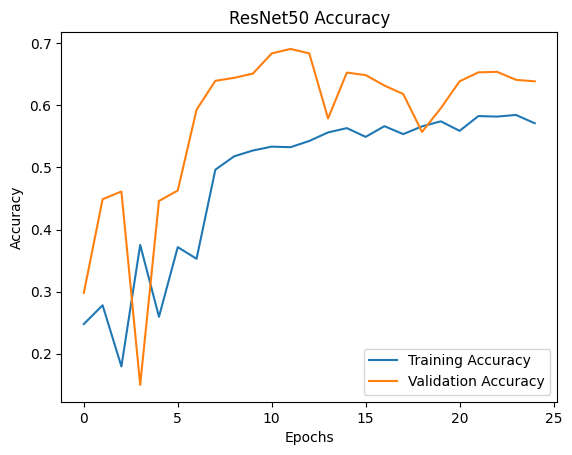

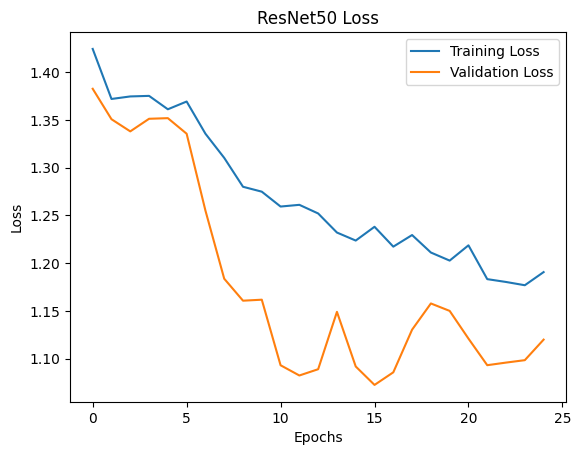

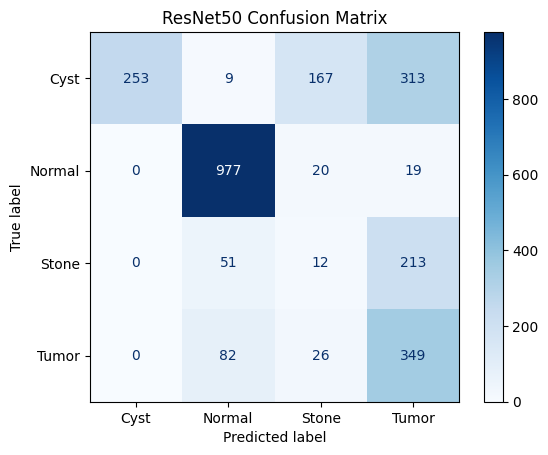

ResNet50 Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      0.34      0.51       742
      Normal       0.87      0.96      0.92      1016
       Stone       0.05      0.04      0.05       276
       Tumor       0.39      0.76      0.52       457

    accuracy                           0.64      2491
   macro avg       0.58      0.53      0.50      2491
weighted avg       0.73      0.64      0.62      2491

ResNet50 Accuracy: 0.6387


In [12]:
# ResNet50

resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMGSIZE, IMGSIZE, 3))
for layer in resnet50_base.layers:
    layer.trainable = False

resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_and_evaluate_model(resnet50_model, x_train, y_train, x_test, y_test, "ResNet50")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


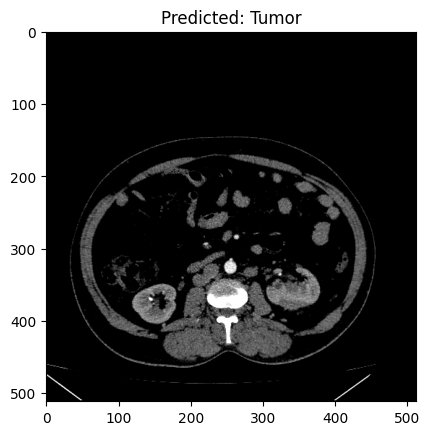

Predicted Class: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


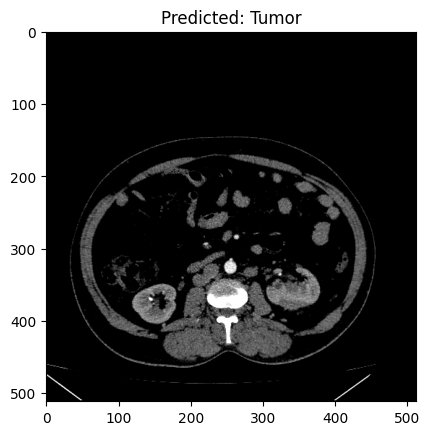

Predicted Class: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


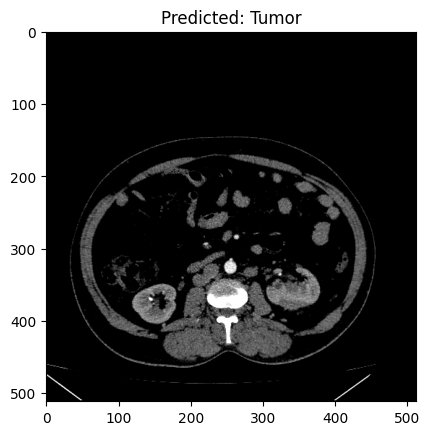

Predicted Class: Tumor


'Tumor'

In [13]:
# Testing with Custom Test Images
def test_model_on_image(model, img_path, img_size=IMGSIZE):
    # Read and preprocess image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize the image
    img = img[tf.newaxis, ...]  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)
    predicted_class = classes[np.argmax(prediction)]
    
    # Display result
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
    
    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Example Test Image
test_img_path = '/kaggle/working/CT_dataset/test/Tumor/Tumor- (1004).jpg'

# Test CNN
test_model_on_image(cnn, test_img_path)

# Test VGG16
test_model_on_image(vgg16_model, test_img_path)

# Test ResNet50
test_model_on_image(resnet50_model, test_img_path)

In [14]:
# Saving the trained models
def save_model(model, model_name):
    model.save(f'{model_name}.h5')
    print(f'{model_name} saved successfully!')

# Save models after training
save_model(cnn, "custom_cnn_model")
save_model(vgg16_model, "vgg16_model")
save_model(resnet50_model, "resnet50_model")

custom_cnn_model saved successfully!
vgg16_model saved successfully!
resnet50_model saved successfully!
